# Interactive Data Science
#### - Vivek Sourabh (Andrew ID - vsourabh)

# Cleaning of Data (<a href='#cleaning'> Detailed Explanation with Code </a>)
<ol>
    <li> All rows with any null values were dropped from the data except for Car Make, Car Model and Description.
        <ul>
            <li> Car Make and Car Model are fixed as per prior knowledge
            <li> Description acts as metadata supporting the other information. With significant amount of null data it did not make sense to drop it
        </ul>
    <li> As VIN number is unique to a car, it can be used as a primary key in the data. All rows with duplicate keys were dropped. (Keeping the first occurence of all VIN Numbers)
    <li> Some Cleaning stratergy was applied to every column.
        <ul>
            <li> Dealer or Individual column does not require any cleaning as the values were same as expected.
            <li> The min and max values of price did not seem on the same scale. So IQR was applied on this column to remove any outliers.
            <li> Location did not a very clear pattern associated with it. Inorder to get some standard values for location a new column 'GeoCodes' was created using the geopy library. This column stores Location Objects and information such as state names and georaphical co-oridinates can be derived from the same when required.
            <li> Year should be an integer column. First it was casted to an integers and all rows that couldn't be casted were removed. And a filter of 2004 (minimum value for year) to 2021(values greater than 2021 not possible) was applied to the same. 
             <li> Mileage again had huge variations in min and max values. Possibly because of the different ways it can be interpreted. (Total miles driven or mile/gallon of gas). Using the prior definition, the outliers were removed. It was also taken into account that older cars are bound to have more mileage according to the above definition. So, IQR was applied on a new column which was normalized with the year of make of the car to account for car age.
             <li> Transmission required no cleaning as data matched expectation.
             <li> Doors again should be an integer type column. So, it was casted to integer and any value that was not a number was removed. Doors was just left with 2 values 4 and 2.
             <li> The records for engine were very dirty mainly because this field was fed in by humans and the data was not recorded in a systematic manner. However, upon closer inspection some words did appear to repeat a lot. So, a corpus of all words excluding stopwords and punctuations was created. These words were arranged into 2-grams and a score was provided to each of them based on how frequently they occured. Then each value apprearing in the engine column was mapped to the an 2-gram with highest score. This helped reduce the number of unique values in engines to 46.
             <li> For Description a approach similar to Engine was applied but rather than 1 2-gram top 5 occuring 2-grams were stored for each row.
             <li> Color also had a lot of variation and inorder to normalize this, the process applied for engines was repeated but with 1-grams instead of 2-grams. This brought down the number of unique colors to 38.
        </ul>
</ol>
    

# Exploratory Data Analysis (<a href='#eda'> Plots and Code </a>)

These are the following observations made from the data and the visualizations for the same can be found in the link above.
<ol>
    <li> Most of the cars are priced in and around 20000 US dollars.
    <li> Most of the cars listed were made in the 2018.
    <li> Most cars on sale are either black, gray or white in color.
    <li> 75% of the cars are driven less than 90000 miles.
    <li> The data is highly skewed towards Automatic cars.
    <li> Majority of the data presents listings made by dealers rather than individuals.
    <li> Most cars listed have 4 doors.
    <li> Cars that were manufactured recently have a higher selling price.
    <li> For most cars the older it is, the more it has been driven.
    <li> There is close to no correlation between color and price of the car.
    <li> Cars with lower mileage tend to have a higher price.
    <li> There is no significant difference of price between Automatic and Manual cars. (Although manual cars are very few)
    <li> Both Dealers and Individuals tend to offer similar prices. (Although Individual listings are very few)
    <li> This data has been collected from around 45 websites, but 7 of them account for about 90% of the data. (carmax.com, cars.com, carvana.com, cargurus.com, carfax.com adn edmunds.com)
    <li> Most of the data (85%) has been collected from Pennsylvania.
    <li> The geographical skewness of data makes it difficult to comment about the prices across various states.
    <li> Five commonly used words to describe the engine are - 4L, Gas Engine, GDI, Cyl, VTEC.
    <li> Five commonly used words used in description are - Keyless Entry, Alloy Wheels, Vanity Mirror, Cruise Control, Air Bag.
    <li> The data also has some new cars, as those cars were made in 2021 and have 0 mileage.
</ol>

# Questions

<ol>
    <li> What should be the expected price for a new Honda Accord listing?
    <li> What distinguishes a listing with accurate and detailed description from a listing with vague and short description?
    <li> What are the demographic features of users who use Honda Accord? For example, is Honda Accord mostly popular in Pennslyvania? If so, is there a certain charactertic that makes it popular here? Like better suited for terrain etc.
</ol>

# Suggestions for Improvement
<ol>
    <li> Minimal manual feeding of data during collection. Fields such as color, location, year and engine should preferably provide a drop down box for users to select from.
    <li> For fields such as description- providing a rubric to fill in the data will help reduce the amount of noise in it.
    <li> Precise definition should be provided for ambiguous term such as mileage.
    <li> The data collection interface (Google Form in this case) should be configured to reject data that does not meet certain requirements. For example, the form should reject an entry which quotes the price to be 1000000 dollars.
    <li> Certain fields should be marked as important and data should not be collected without that field. For example, it an individual must not be able to submit the form bu just filling in the description.
</ol>

# Code and Implementation

In [66]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams
import string
import requests
from geopy.geocoders import Nominatim
import time
import xlsxwriter

In [67]:
%matplotlib inline
english_stopwords = set(nltk.corpus.stopwords.words('english'))

# 1. Reading Data

In [68]:
df = pd.read_csv("IDSF21-Homework 1.csv", encoding="ISO-8859-1")
print(df.dtypes)

Timestamp                object
Car Make                 object
Car Model                object
Dealer or Individual     object
Price                   float64
Year                     object
Location                 object
Mileage                 float64
Doors                    object
Color                    object
Transmission             object
VIN#                     object
Engine                   object
Description              object
Web link                 object
dtype: object


# 2. Cleaning Data
<a id="cleaning"></a>

### 2.1 We handle the null values for each column in accordance to the guidelines below-


##### Number of null values in each column

In [69]:
df.isna().sum()

Timestamp                 0
Car Make                  1
Car Model                 1
Dealer or Individual     11
Price                     4
Year                      1
Location                 40
Mileage                  10
Doors                    20
Color                     5
Transmission              5
VIN#                      8
Engine                   36
Description             327
Web link                  4
dtype: int64

In [70]:
df['Car Make'].fillna("Honda", inplace=True)
df['Car Model'].fillna("Accord", inplace=True)
df['Description'].fillna("Unknown", inplace=True)
df['Web link'].fillna("https://www.null.com/", inplace=True)

In [71]:
df.dropna(how='any', inplace=True)

### 2.2 We now drop duplicate rows in the data based on the VIN number as it is Unique to every car

In [72]:
df.duplicated(subset=['VIN#']).sum()

305

In [73]:
df.drop_duplicates(subset=['VIN#'], inplace=True)

### 2.3 We perform some cleaning based on the values observed in each of the columns

##### Dealer or Individual (No cleaning Required as all values observed are expected)

In [74]:
df['Dealer or Individual'].unique()

array(['Dealer', 'Individual'], dtype=object)

##### Price
1. Some of the minimum and maximum values in the price data seem to vary by a lot.
2. We plot a box plot in order to see if there are any outliers
3. We then perform a standrad IQR technique to remove any potential outliers
4. Performing analysis on the exact values of prices makes little sense so we add a new column Price Bucket that clubs the sizes into bins of $1000.

In [75]:
df['Price'].describe()

count       652.000000
mean      18898.938650
std        9648.770781
min        2000.000000
25%       13999.750000
50%       19590.000000
75%       23590.000000
max      202897.000000
Name: Price, dtype: float64

<AxesSubplot:>

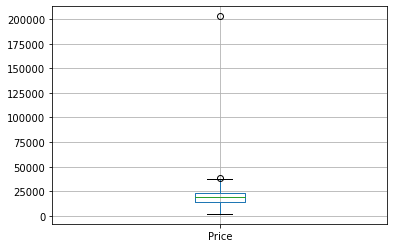

In [76]:
df.boxplot(column=['Price'])

In [77]:
price_q1 = df['Price'].quantile(0.25)
price_q3 = df['Price'].quantile(0.75)
price_iqr = price_q3-price_q1
price_filter = (df['Price']>=price_q1 -  1.5*price_iqr) & (df['Price']<= price_q3 + 1.5*price_iqr)
df = df.loc[price_filter]

In [78]:
df['Price'].describe()

count      650.000000
mean     18586.001538
std       6367.237751
min       2000.000000
25%      13999.250000
50%      19558.000000
75%      23498.500000
max      37815.000000
Name: Price, dtype: float64

<AxesSubplot:>

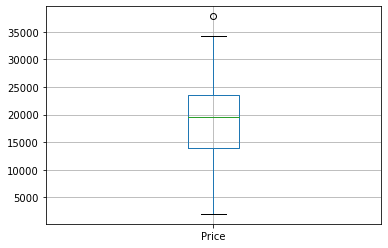

In [79]:
df.boxplot(column=['Price'])

In [80]:
df['Price Bucket'] = ((df['Price']//1000+1))*1000

##### Location
1. On observing the values in the location column there is no significant pattern that is being followed in order to extract a standard form of address.
2. We use the geopy library to convert them to geopy location objects which would help make the address representation uniform to some extent

In [60]:
geolocator = Nominatim(user_agent="viveksourabh2010@gmail.com")
list_locations = list(df['Location'])
geocodes = []
for locs in list_locations:
    time.sleep(1)
    geocodes.append(geolocator.geocode(locs))

In [81]:
df['GeoCodes'] = geocodes

### Year
1. The year should ideally be an integer with value lower than 2021.
2. We remove all rows where the year value cannot be casted to an integer or are integers greater than 2021.

In [109]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [110]:
df = df[df['Year'].notna()]

In [112]:
df = df.loc[(df['Year']>=2004) & (df['Year']<=2021)]

In [114]:
df['Year'].describe()

count     647.000000
mean     2015.034003
std         3.164052
min      2004.000000
25%      2013.000000
50%      2016.000000
75%      2018.000000
max      2021.000000
Name: Year, dtype: float64

### Mileage
 1. With Mileage as well we can se a lot of variation n the min and max values.
 2. This can be attributed to the fact that Mileage can have multiple definitions <br>
     2.1 Total Miles run by the car <br>
     2.2 Number of miles/gallon of gas <br>
 3. We use the definition of Mileage as total distance travelled by the car
 4. Based on this definition we clean the outliers using IQR
 5. Another aspect of using the above definition is that a model is that an older car in theory should have run many more miles as compared to a newer car. 
 6. The above fact is evident from the analysis below.
 7. Inorder to handle the case above we add a new column which is the mileage of the car normalized by the total number of years it has run and perform IQR on this new column
 8. Similar to Price we also bucket mileage but into bins of 10000.

In [102]:
df['Mileage'].describe()

count       650.000000
mean      64983.500000
std       50496.544513
min           0.000000
25%       30207.750000
50%       53656.500000
75%       91610.250000
max      559857.000000
Name: Mileage, dtype: float64

In [105]:
df[['Mileage', 'Year']].groupby('Year').median()

,Mileage
Year,
2004,147515.0
2005,161783.5
2006,113887.0
2007,147081.0
2008,135800.0
2009,137991.5
2010,107576.0
2010W,161844.0
2011,136115.0


<AxesSubplot:>

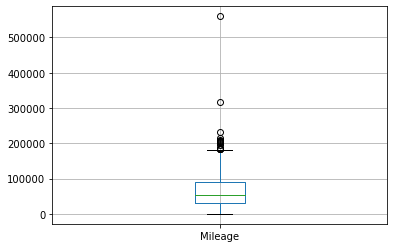

In [115]:
df.boxplot(column=['Mileage'])

In [116]:
df['avg_mile'] = df['Mileage']/(df['Year']-2003)

In [118]:
mile_q1 = df['avg_mile'].quantile(0.25)
mile_q3 = df['avg_mile'].quantile(0.75)
mile_iqr = mile_q3-mile_q1
mile_filter = (df['avg_mile']>=price_q1 -  1.5*price_iqr) & (df['avg_mile']<= price_q3 + 1.5*price_iqr)
df = df.loc[mile_filter]

In [120]:
df = df.drop(['avg_mile'], axis=1)

<AxesSubplot:>

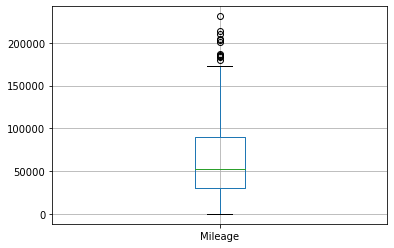

In [123]:
df.boxplot(column=['Mileage'])

In [124]:
df['Mileage'].describe()

count       640.000000
mean      62846.243750
std       44499.858171
min           0.000000
25%       29981.250000
50%       52675.000000
75%       89732.750000
max      231080.000000
Name: Mileage, dtype: float64

In [185]:
df['Mileage Bucket'] = ((df['Mileage']//10000)+1)*10000

### Transmission
1. No cleaning required as values are as expected

In [127]:
df['Transmission'].unique()

array(['Automatic', 'Manual'], dtype=object)

### Doors
1. Doors again should be an integer and any other value should be dropped
2. Applying the above filter we find that the values observed in the column are as expected

In [128]:
df['Doors'] = pd.to_numeric(df['Doors'], errors='coerce')
df = df[df['Doors'].notna()]

In [129]:
df['Doors'].unique()

array([4., 2.])

### Engine
1. The engine data being too random it is difficult to derive any standard form from the data.
2. In order to derive some standard values, we create a corpus of 2-grams from all the values that occur in the engine column and count the occurences of these 2-grams across the complete data.
3. We then add a new column Engine_Derived which is replaced by the most common occurence that matches the engine description.

In [135]:
def extract_ngrams(data, num):
    tokens = nltk.word_tokenize(data)
    clean_tokens = []
    for t in tokens:
        a = t.strip()
        if a.lower() not in english_stopwords and a.lower() not in string.punctuation:
            clean_tokens.append(a.lower())
    n_grams = ngrams(clean_tokens, num)
    return [ ' '.join(grams) for grams in n_grams]

In [141]:
engine_specs = list(df['Engine'])
engine_corpus = ' '.join(engine_specs)
engine_2grams = extract_ngrams(engine_corpus, 2)
engine_dict = dict(Counter(engine_2grams))

In [144]:
def get_engine_value(engine_specs):
    engine_words = extract_ngrams(engine_specs, 2)
    score = 0
    ans_string = ""
    for gram in engine_words:
        if engine_dict[gram]>score:
            score = engine_dict[gram]
            ans_string = gram
    return ans_string

In [145]:
df["Engine_Derived"] = df.apply(lambda row: get_engine_value(row['Engine']), axis=1)

In [148]:
df['Engine_Derived'].unique().shape

(46,)

### Description
1. Description again is similar to the engine field with no defined format.
2. We perform the same analysis as done on engine but this time select 5 most common 2-grams
3. Using these 2-grams we try to find the best summary for each row.

In [151]:
description_specs = list(df['Description'])
description_corpus = ' '.join(description_specs)
description_2grams = extract_ngrams(description_corpus, 2)
description_dict = dict(Counter(description_2grams))

In [164]:
def get_top_descriptors(desc):
    desc_words = extract_ngrams(desc, 2)
    words = {}
    for gram in desc_words:
        words[gram] = description_dict[gram]
    sorted_dict = sorted(words.items(), key = lambda kv: kv[1], reverse=True)
    ans = []
    max_index = min(5, len(sorted_dict))
    for i in range(max_index):
        ans.append(sorted_dict[i][0])
    return str(ans)

In [165]:
df["Description_Derived"] = df.apply(lambda row: get_top_descriptors(row['Description']), axis=1)

### Color
1. Color again displays similar properties to Engine and Description.
2. So we do the same again but with 1 grams

In [167]:
color_specs = list(df['Color'])
color_corpus = ' '.join(color_specs)
color_1grams = extract_ngrams(color_corpus, 1)
color_dict = dict(Counter(color_1grams))

In [170]:
def get_color_value(color):
    color_words = extract_ngrams(color, 1)
    score = 0
    ans_string = ""
    for gram in color_words:
        if color_dict[gram]>score:
            score = color_dict[gram]
            ans_string = gram
    return ans_string

In [171]:
df['Color_Derived'] = df.apply(lambda row: get_color_value(row['Color']), axis=1)

# 3. Saving Data

In [291]:
options = {}
options['strings_to_formulas'] = False
options['strings_to_urls'] = False
writer = pd.ExcelWriter('IDS_Data.xlsx',engine='xlsxwriter',options=options)
df.to_excel(writer, 'Sheet_A', index=False)
writer.save()

/var/folders/ls/6136ly6n301gs_43z_gxkz5w0000gn/T/ipykernel_31764/2973851923.py:4: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  writer = pd.ExcelWriter('IDS_Data.xlsx',engine='xlsxwriter',options=options)


# Exploratory Data Analysis
<a id='eda'>

### Distribution of Cars by Price

/var/folders/ls/6136ly6n301gs_43z_gxkz5w0000gn/T/ipykernel_31764/2733734229.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  price_plot.set_xticklabels(price_plot.get_xticks(), size=15)


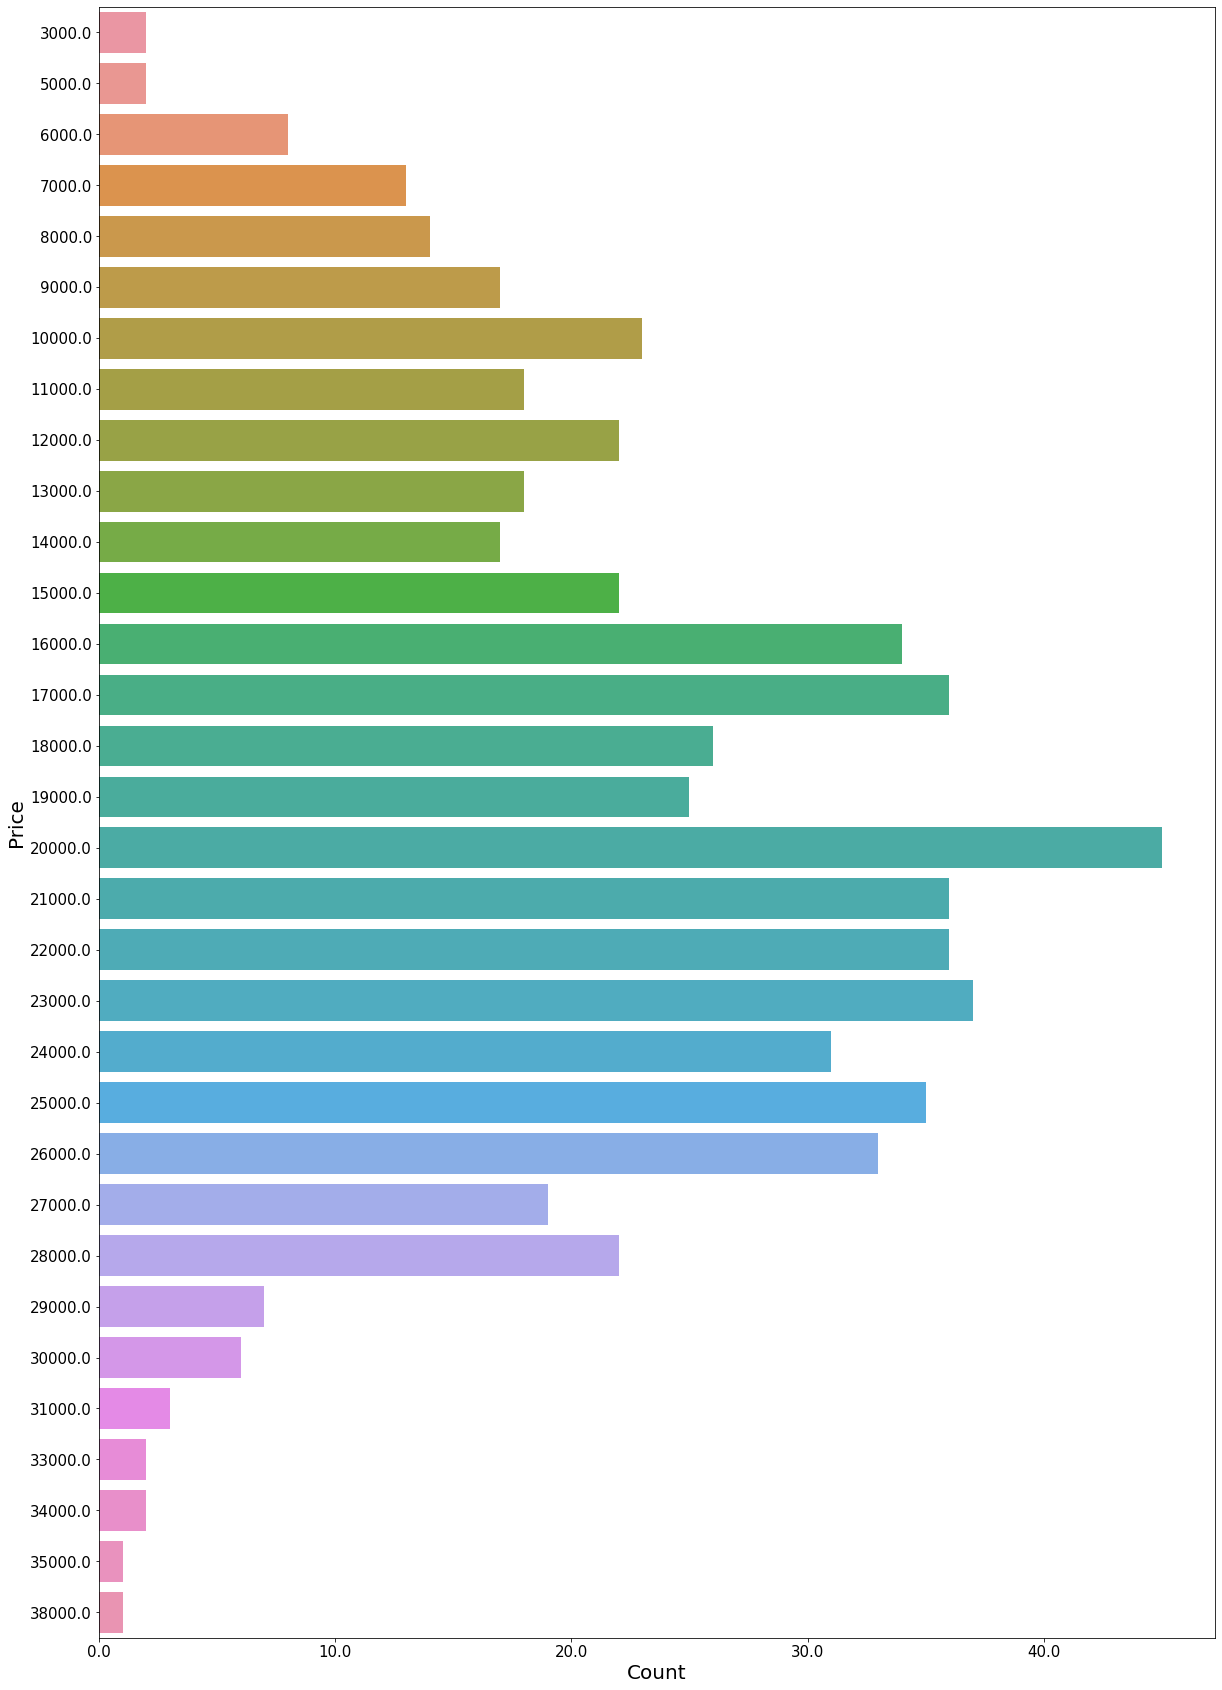

In [177]:
df_prices = df.groupby(['Price Bucket']).size()
df_prices = df_prices.sort_index()
ylabel = list(df_prices.values)
fig1, ax1 = plt.subplots(figsize=(20, 30))
price_plot = sns.barplot(ax=ax1, y=df_prices.index, x=df_prices.values, orient='h')
price_plot.set_yticklabels(df_prices.index, size=15)
price_plot.set_ylabel("Price", size=20)
price_plot.set_xticklabels(price_plot.get_xticks(), size=15)
price_plot.set_xlabel("Count", size=20)
plt.show()

### Number of Cars from each year

<AxesSubplot:xlabel='Year'>

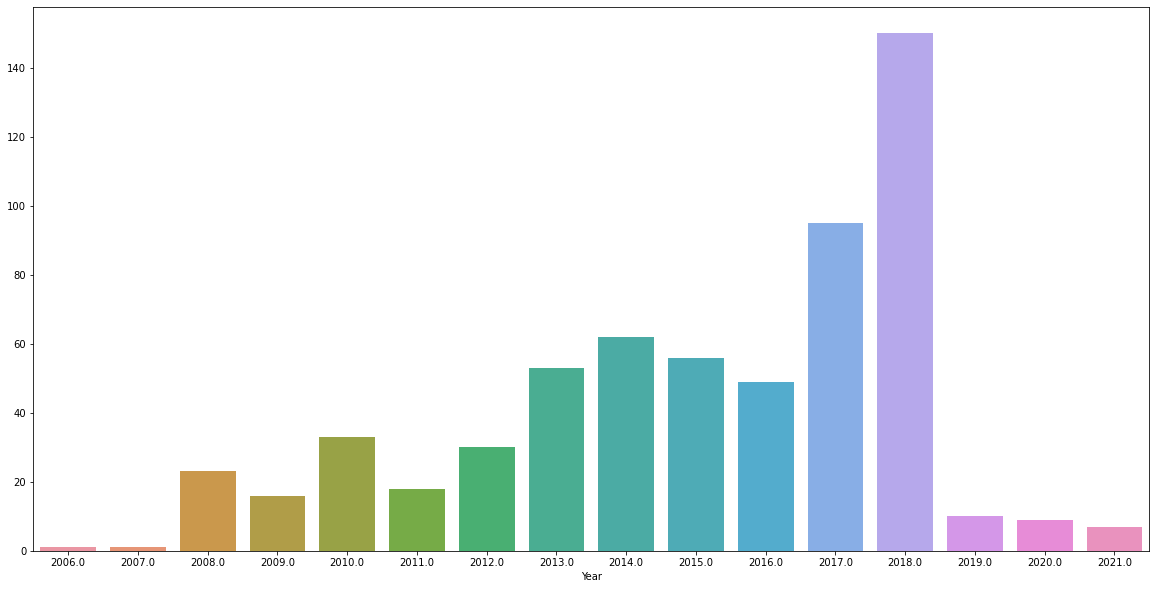

In [178]:
df_year = df.groupby(['Year']).size()
fig2, ax2 = plt.subplots(figsize=(20, 10))
sns.barplot(ax=ax2, x=df_year.index, y=df_year.values)

### Numbers of Cars by Color

<AxesSubplot:ylabel='Color_Derived'>

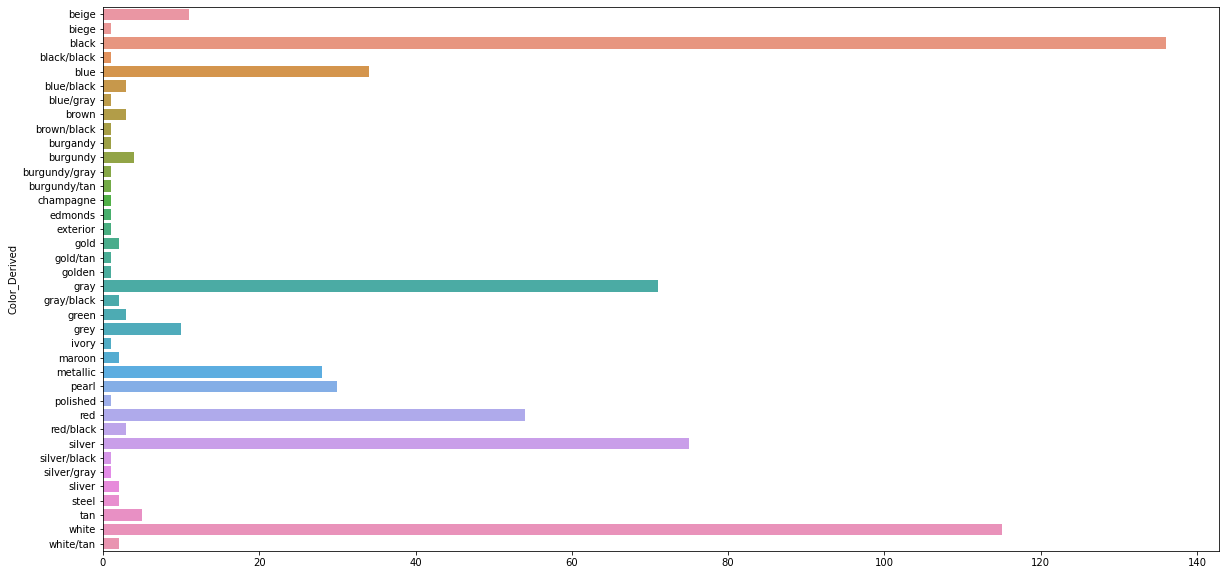

In [182]:
df_color = df.groupby(['Color_Derived']).size()
fig2, ax2 = plt.subplots(figsize=(20, 10))
sns.barplot(ax=ax2, y=df_color.index, x=df_color.values, orient='h')

### Number of cars by Mileage Bin

<AxesSubplot:ylabel='Mileage Bucket'>

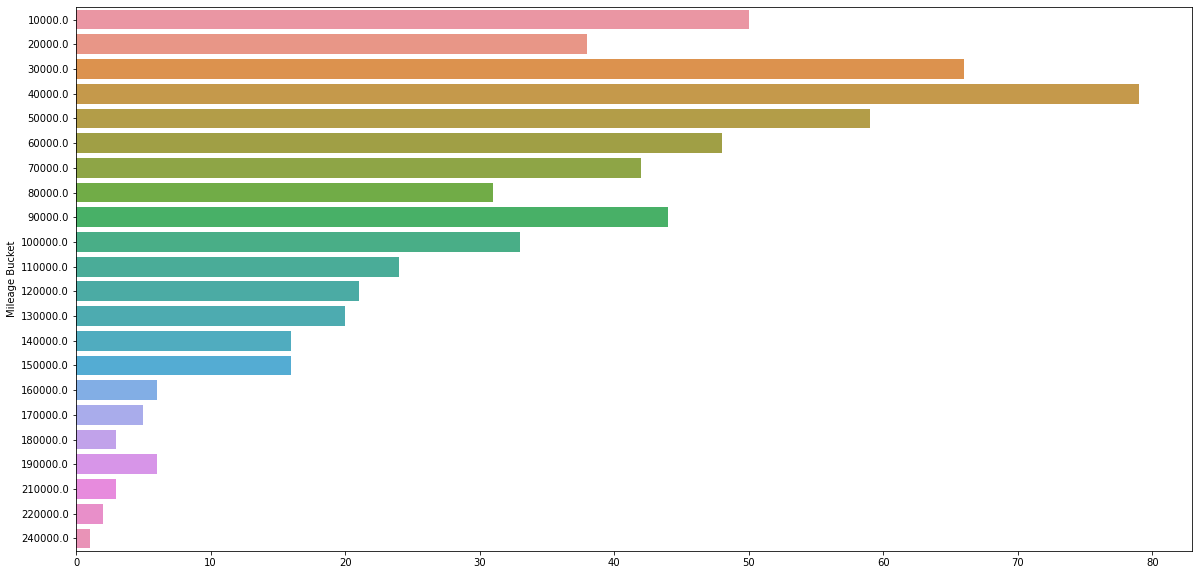

In [187]:
df_mile = df.groupby(['Mileage Bucket']).size()
fig2, ax2 = plt.subplots(figsize=(20, 10))
sns.barplot(ax=ax2, y=df_mile.index, x=df_mile.values, orient='h')

### Number of cars by Transmission

<AxesSubplot:xlabel='Transmission'>

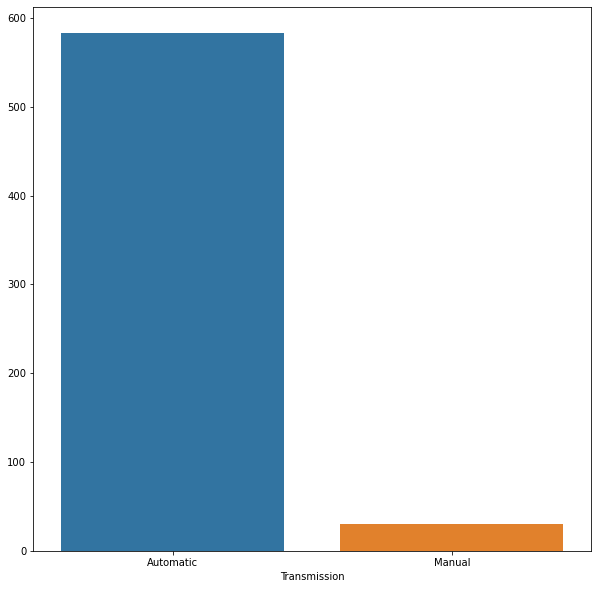

In [190]:
df_transmission = df.groupby(['Transmission']).size()
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, x=df_transmission.index, y=df_transmission.values)

### Number of Cars by Seller Type

<AxesSubplot:xlabel='Dealer or Individual'>

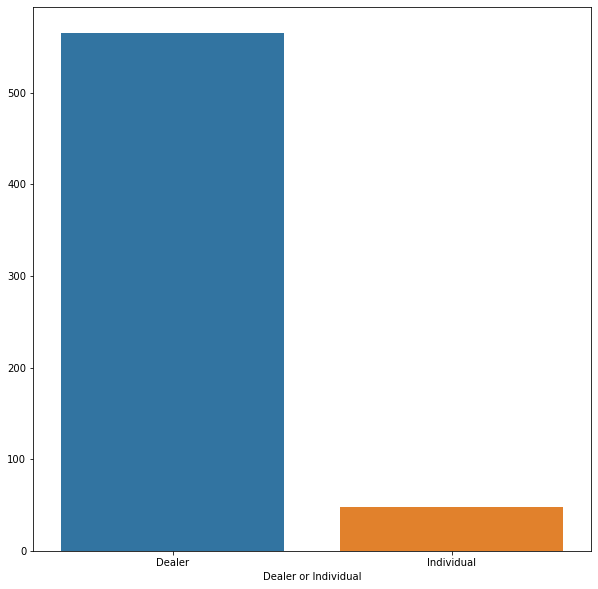

In [191]:
df_seller = df.groupby(['Dealer or Individual']).size()
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, x=df_seller.index, y=df_seller.values)

### Distribution of cars with number of doors

<AxesSubplot:xlabel='Doors'>

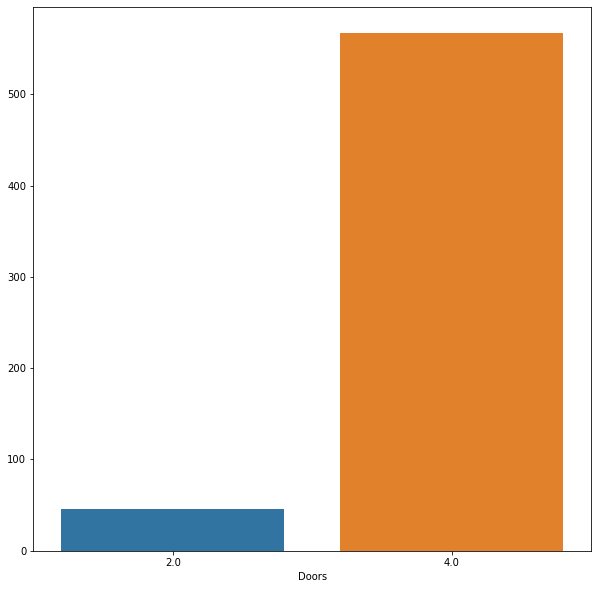

In [192]:
df_door = df.groupby(['Doors']).size()
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, x=df_door.index, y=df_door.values)

### Price v/s Year

<AxesSubplot:xlabel='Year', ylabel='Price'>

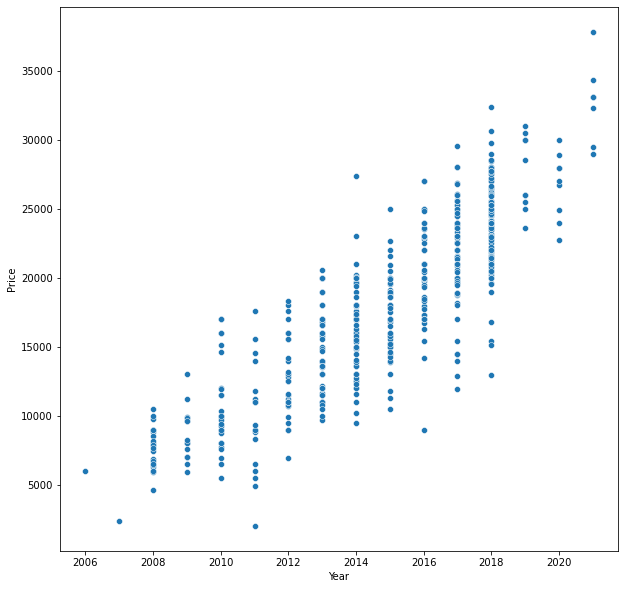

In [194]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax2, x=df.Year, y=df.Price)

### Mileage v/s Year

<AxesSubplot:xlabel='Year', ylabel='Mileage'>

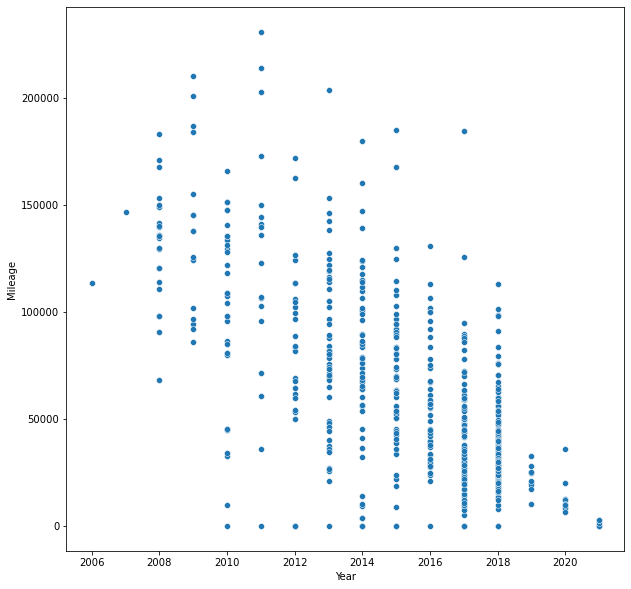

In [195]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax2, x=df.Year, y=df.Mileage)

### Price v/s Color

<AxesSubplot:ylabel='Color_Derived'>

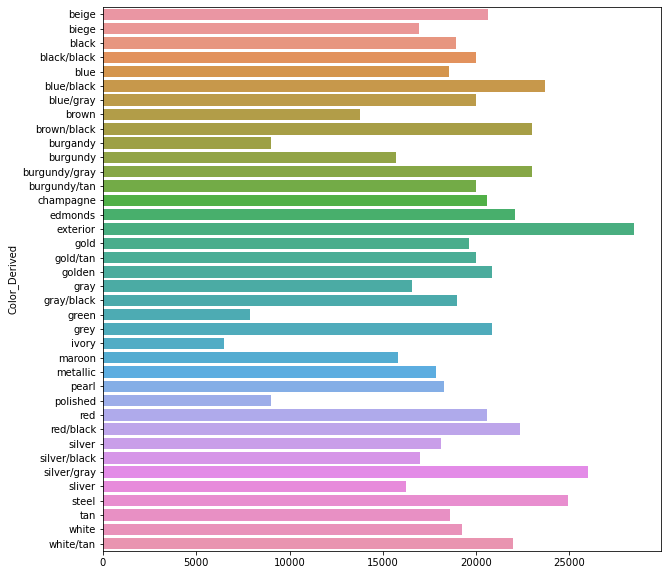

In [206]:
df_avg = df.groupby('Color_Derived').mean()['Price']
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, y=df_avg.index, x=df_avg.values, orient='h')

### Price v/s Mileage

<AxesSubplot:xlabel='None-Mileage Bucket', ylabel='Price Bucket'>

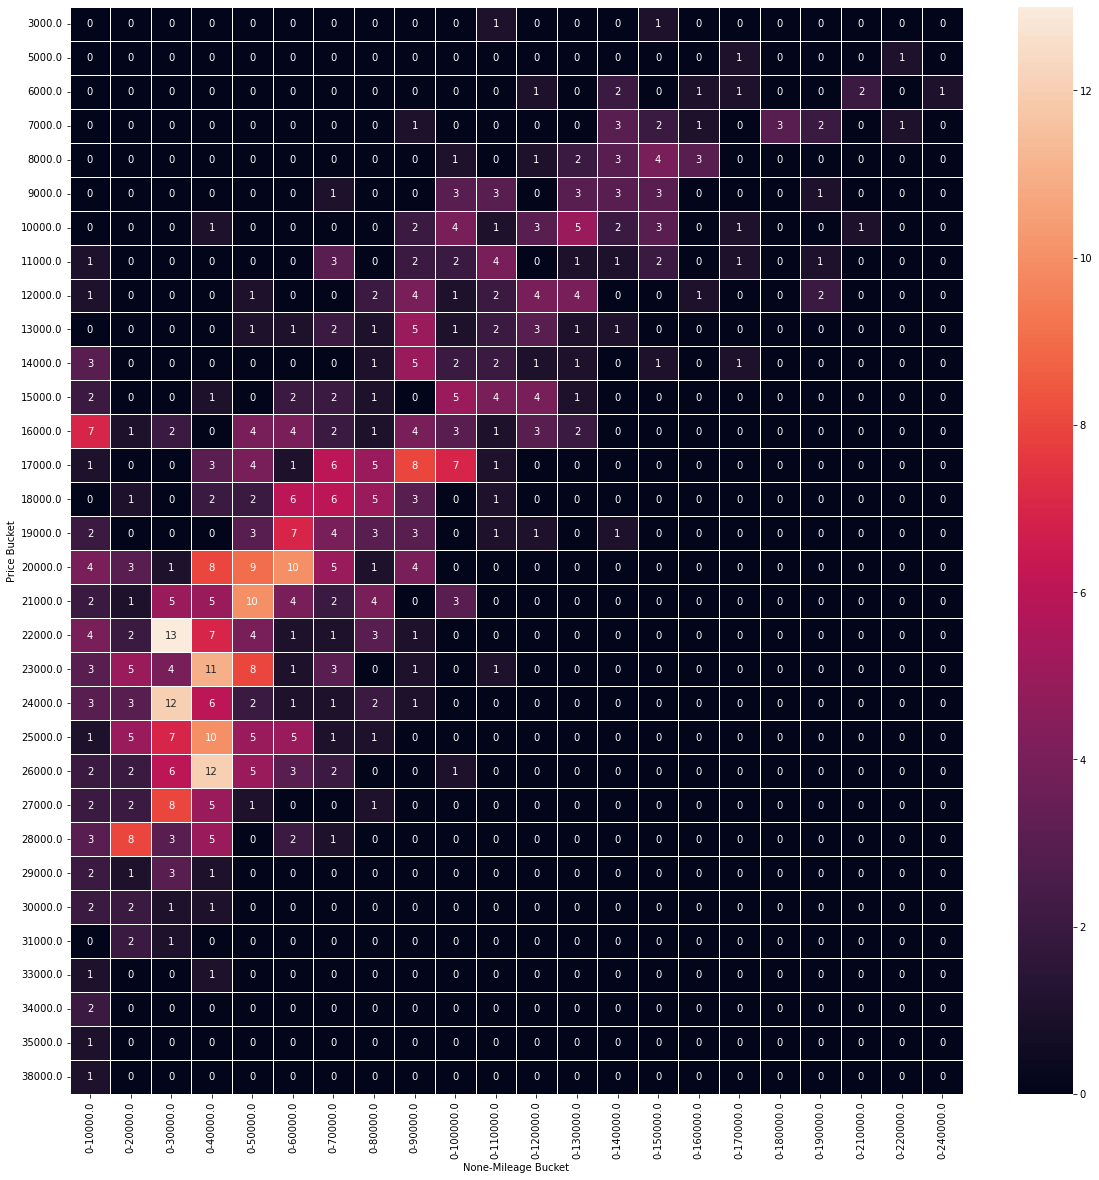

In [224]:
df_avg = df.groupby(['Price Bucket', 'Mileage Bucket']).size()
df_avg = df_avg.reset_index()
df_avg = df_avg.pivot("Price Bucket", "Mileage Bucket")
df_avg = df_avg.fillna(0)
fig2, ax2 = plt.subplots(figsize=(20, 20))
sns.heatmap(df_avg, annot=True, linewidth=0.5)

### Price v/s Transmission

<AxesSubplot:xlabel='Transmission'>

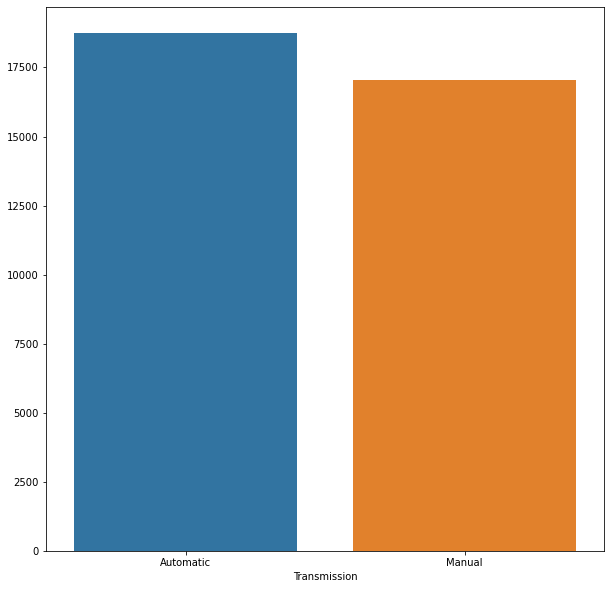

In [226]:
df_avg = df.groupby('Transmission').mean()['Price']
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, x=df_avg.index, y=df_avg.values)

### Price v/s Seller

<AxesSubplot:xlabel='Dealer or Individual'>

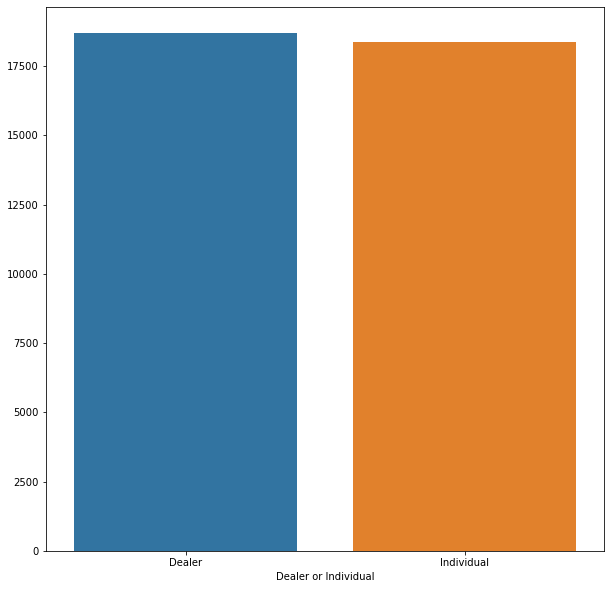

In [227]:
df_avg = df.groupby('Dealer or Individual').mean()['Price']
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, x=df_avg.index, y=df_avg.values)

## Derive Website and Location Info

In [241]:
def get_website(url):
    l = url.split('/')
    try:
        return l[2]
    except:
        return "Unknown"

def get_location(address):
    l = str(address).split(',')
    try:
        state = l[-2].strip()
        if state.isdigit():
            return l[-3].strip()
        return state
    except:
        return "Unknown"
    

In [242]:
df1 = df

In [243]:
df1['Website'] = df1.apply(lambda row: get_website(row['Web link']), axis=1)
df1['State'] = df1.apply(lambda row: get_location(row['GeoCodes']), axis=1)

### Count Across Websites

<AxesSubplot:ylabel='Website'>

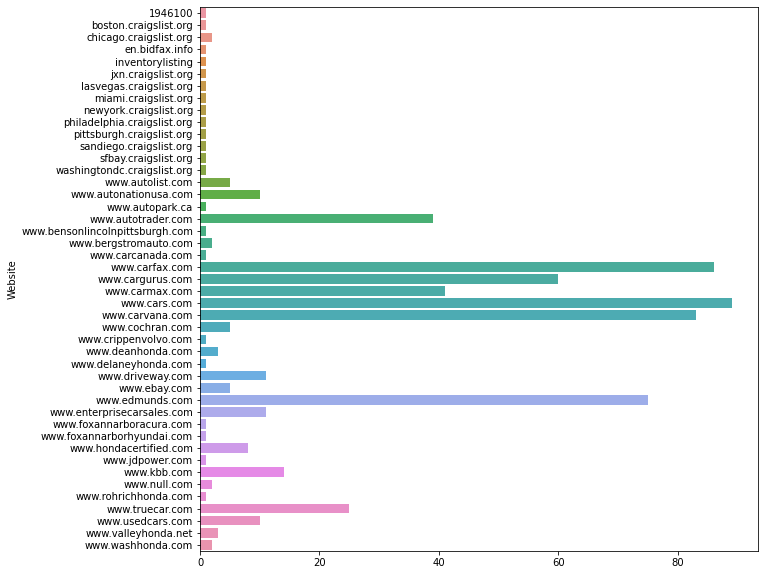

In [248]:
df_avg = df1.groupby('Website').size()
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, y=df_avg.index, x=df_avg.values, orient='h')

### Price across websites

<AxesSubplot:ylabel='Website'>

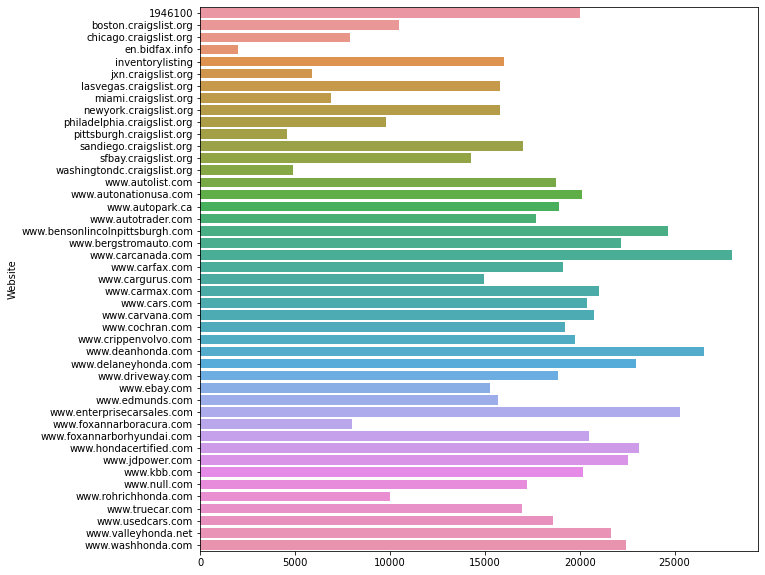

In [249]:
df_avg = df1.groupby('Website').mean()['Price']
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.barplot(ax=ax2, y=df_avg.index, x=df_avg.values, orient='h')

### Year across websites

<AxesSubplot:xlabel='Year', ylabel='Website'>

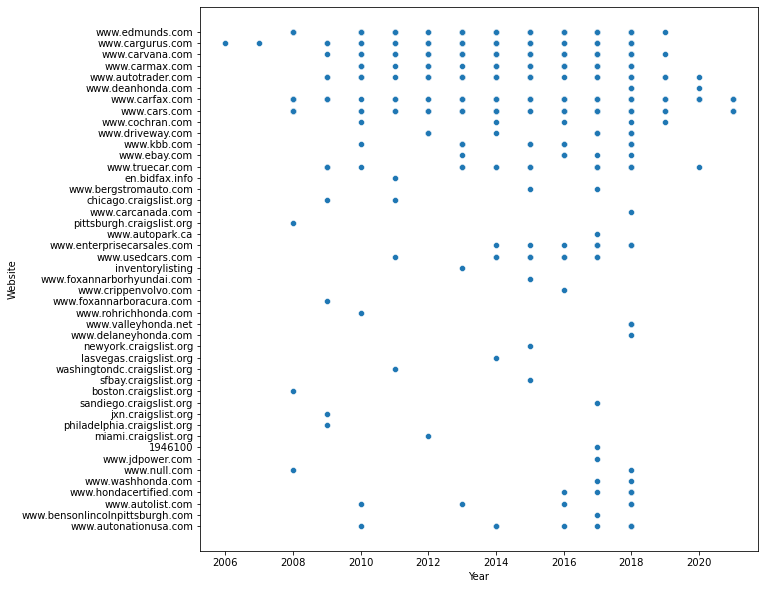

In [256]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax2, y=df1.Website, x=df1.Year)

### Count Across States

<AxesSubplot:ylabel='State'>

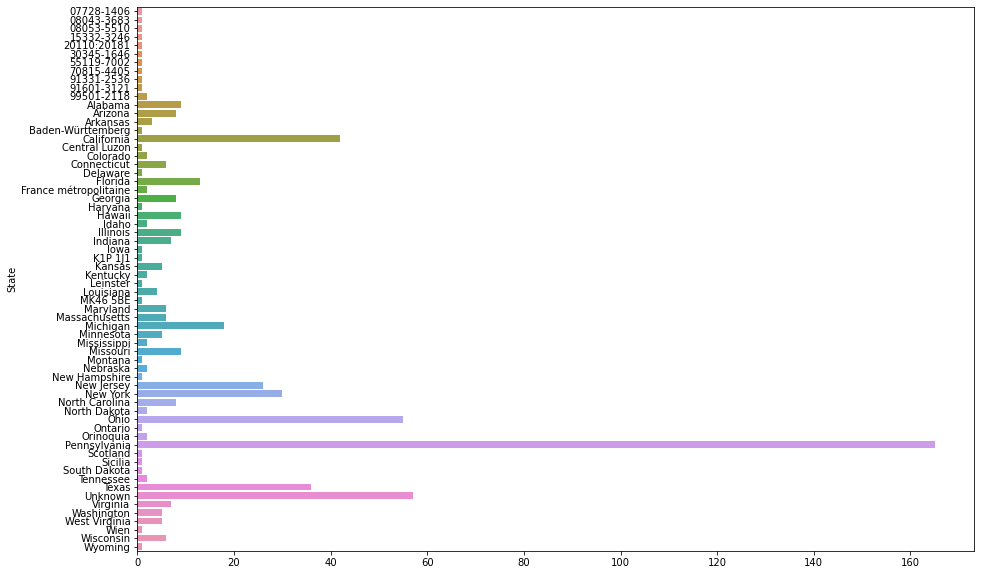

In [258]:
df_avg = df1.groupby('State').size()
fig2, ax2 = plt.subplots(figsize=(15, 10))
sns.barplot(ax=ax2, y=df_avg.index, x=df_avg.values, orient='h')

### Price across States

<AxesSubplot:ylabel='State'>

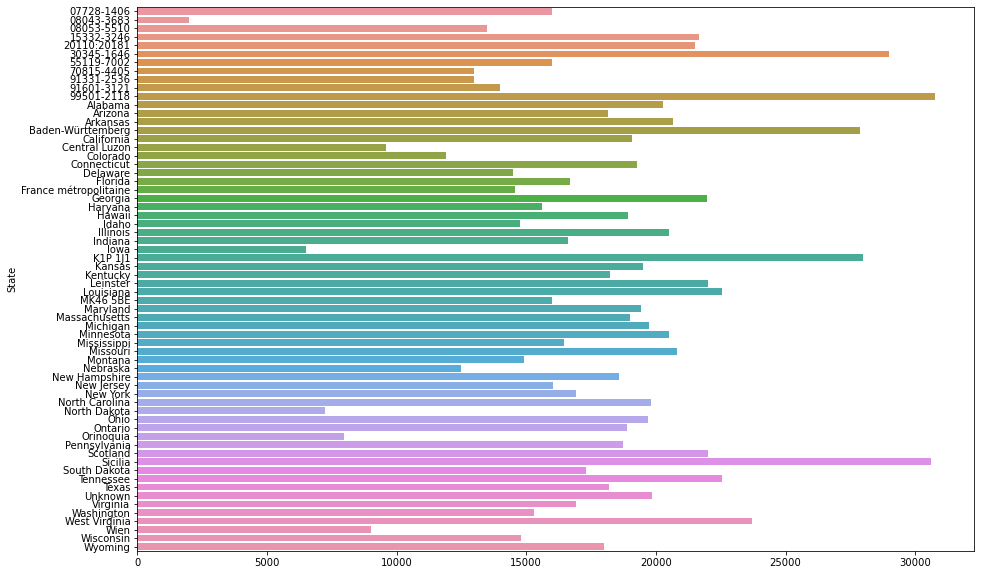

In [261]:
df_avg = df1.groupby('State').mean()['Price']
fig2, ax2 = plt.subplots(figsize=(15, 10))
sns.barplot(ax=ax2, y=df_avg.index, x=df_avg.values, orient='h')

### Year across States

<AxesSubplot:xlabel='Year', ylabel='State'>

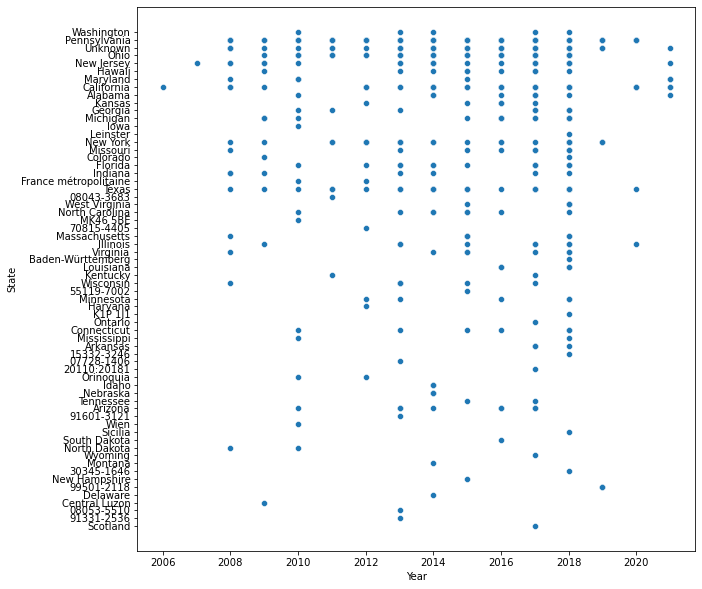

In [262]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
sns.scatterplot(ax=ax2, y=df1.State, x=df1.Year)

### Website Preference of Dealers/Individuals

<AxesSubplot:xlabel='None-Dealer or Individual', ylabel='Website'>

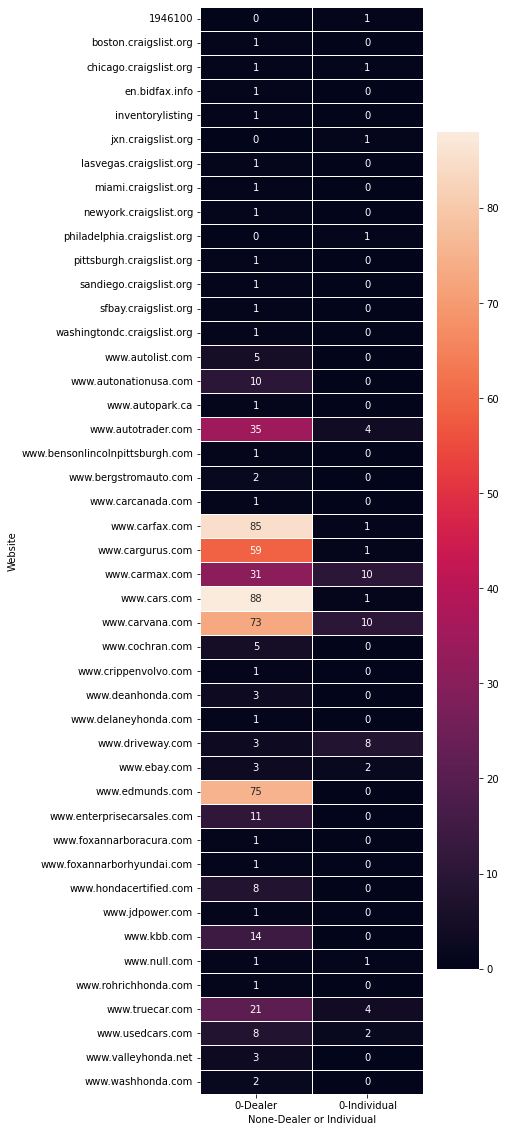

In [265]:
df_avg = df1.groupby(['Website', 'Dealer or Individual']).size()
df_avg = df_avg.reset_index()
df_avg = df_avg.pivot('Website', 'Dealer or Individual')
df_avg = df_avg.fillna(0)
fig2, ax2 = plt.subplots(figsize=(5, 20))
sns.heatmap(df_avg, annot=True, linewidth=0.5)

### Most Common words for Engine

(-0.5, 719.5, 719.5, -0.5)

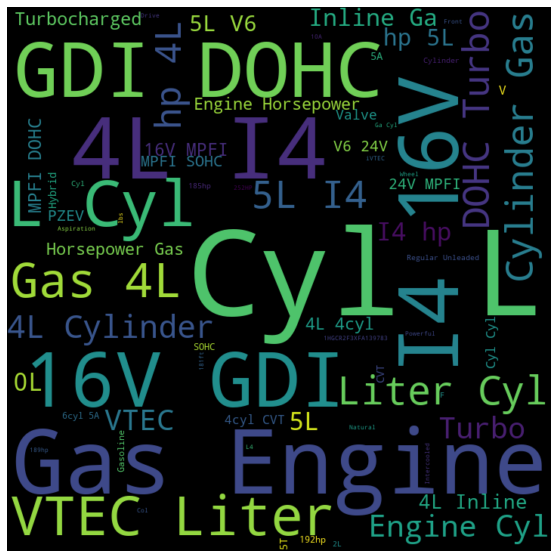

In [278]:
wordcloud = WordCloud(width=720, height=720, margin=0).generate(engine_corpus)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Most common Words in Description

(-0.5, 719.5, 719.5, -0.5)

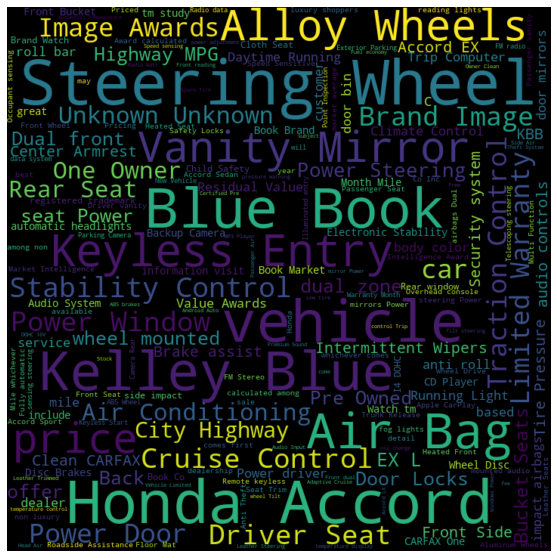

In [280]:
wordcloud = WordCloud(width=720, height=720, margin=0).generate(description_corpus)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")